In [ ]:
import kagglehub

path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = f"{path}/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_dir = f"{dataset_path}/train"
val_dir = f"{dataset_path}/val"
test_dir = f"{dataset_path}/test"

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
from torchvision.transforms.v2 import TrivialAugmentWide

data_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
val_data = datasets.ImageFolder(root=val_dir, transform=test_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform, target_transform=None)

In [ ]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
import torch
from torch import nn

In [ ]:
class Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 72 * 72, out_features=output_shape),
        )
    def forward(self, x):
        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(42)
model = Model(input_shape=3, output_shape=1, hidden_units=32)

In [ ]:
model(torch.rand(1, 3, 300,300))

tensor([[1.2320]], grad_fn=<AddmmBackward0>)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model.to(device)

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=Fa

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       factor=0.1,
                                                       patience=3,
                                                       )

In [ ]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_true) * 100

In [ ]:
import os

results_path = "/content/drive/My Drive/results"
if not os.path.exists(results_path):
    os.mkdir(results_path)
    print("created")

created


In [ ]:
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f"{results_path}/runs")

epochs = 15
patience = 6
early_stop = 0
best_loss = None

for epoch in tqdm(range(1, epochs + 1)):
    train_acc, train_loss = 0, 0
    model.train()
    for batch, (X, y) in tqdm(enumerate(train_data_loader), desc=f"Training epoch {epoch} ->", total=len(train_data_loader), leave=False):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        y = y.unsqueeze(dim=1).float()
        loss = loss_fn(logits, y)
        y_preds = torch.round(torch.sigmoid(logits))
        train_loss += loss.item()
        train_acc += acc_fn(y, y_preds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_loader)
    train_acc /= len(train_data_loader)

    val_acc, val_loss = 0, 0
    model.eval()
    for batch, (X, y) in tqdm(enumerate(val_data_loader), desc=f"Validating epoch {epoch} ->", total=len(val_data_loader), leave=False):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        y = y.unsqueeze(1).float()
        y_preds =torch.round(torch.sigmoid(logits))
        val_loss += loss_fn(logits, y).item()
        val_acc += acc_fn(y, y_preds)
    val_loss /= len(val_data_loader)
    val_acc /= len(val_data_loader)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    info = f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | Val loss: {val_loss:.5f} | Val acc: {val_acc:.5f}"
    with open(f"{results_path}/training_info.txt", "a") as f:
        f.write(info + "\n")

    print(info)

    if new_lr < old_lr:
        print(f"Learning rate is reduced from: {old_lr} to {new_lr}")

    writer.add_scalars("Loss", tag_scalar_dict={"Train loss": train_loss, "Val loss": val_loss}, global_step=epoch)
    writer.add_scalars("Accuracy", tag_scalar_dict={"Train acc": train_acc, "Val acc": val_acc}, global_step=epoch)
    writer.add_scalar("Learning rate", optimizer.param_groups[0]['lr'], global_step=epoch)

    if best_loss is None:
        best_loss = val_loss
        print(f"Best model saved after epoch: {epoch}")
        torch.save(model, f"{results_path}/model.pth")
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop = 0
        print(f"Best model saved after epoch: {epoch}")
        torch.save(model, f"{results_path}/model.pth")
    else:
        early_stop += 1
        if early_stop == patience:
            print(f"early stopping triggered")
            break

In [ ]:
test_preds = []
test_loss, test_acc = 0, 0
model = torch.load(f"{results_path}/model.pth", weights_only=False)
model.eval()
with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_data_loader), leave=False, total=len(test_data_loader), desc=f"Testing ->"):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        y = y.unsqueeze(1).float()
        test_loss += loss_fn(logits, y).item()
        y_pred = torch.round(torch.sigmoid(logits))
        test_acc += acc_fn(y, y_pred)
        test_preds.append(y_pred.cpu())
    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

test_preds = torch.cat(test_preds)
test_loss, test_acc

Testing ->:   0%|          | 0/16 [00:00<?, ?it/s]

(0.0974754795897752, 96.84495192307692)

In [ ]:
try:
    from torchmetrics import ConfusionMatrix
except:
    !pip install torchmetrics


from torchmetrics import ConfusionMatrix

cm = ConfusionMatrix(task="binary", num_classes=2)
conf_mat = cm(test_preds.squeeze(), torch.Tensor(test_data.targets).type(torch.int64))

In [ ]:
class_names = test_data.classes

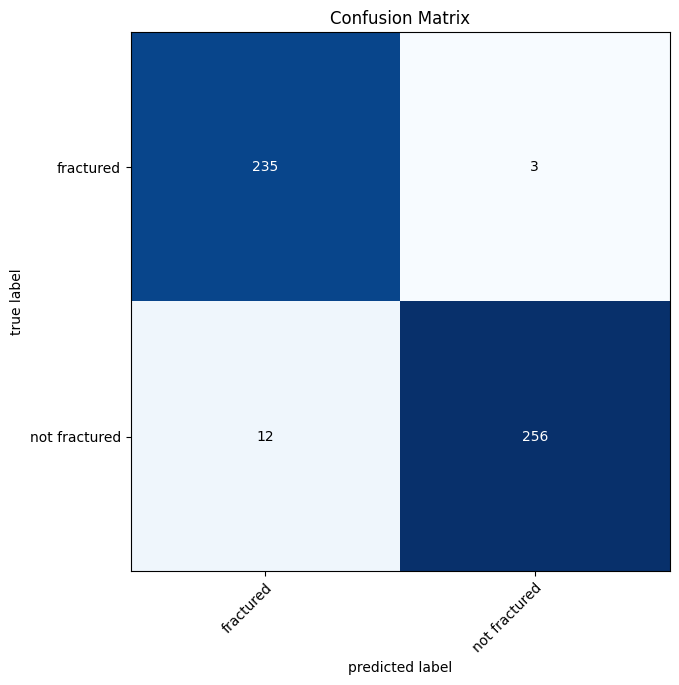

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(conf_mat=conf_mat.numpy(), class_names=class_names, figsize=(7, 7))
plt.title("Confusion Matrix")
plt.savefig(f"{results_path}/confusion_matrix.png", dpi=1000)

In [ ]:
from sklearn.metrics import classification_report

with open(f"{results_path}/classification_report.txt", "w") as f:
    f.write(str(classification_report(test_preds, torch.Tensor(test_data.targets).type(torch.int64))))

In [ ]:
print(conf_mat)

tensor([[235,   3],
        [ 12, 256]])
